In [1]:
## Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
## Pay-to-exit research questions
## RQ1 For an adversary with \alpha stake, how much does it need to pay to
## exiting validators to achieve \alpha'\leq0.33 stake in the system? In this scenario the adversary would
## reimburse all expected rewards to the validator for the next 1-2-3 (TBD) years (discounted at present value).
## RQ2 The same as in RQ1 but the adversary only reimburses the opportunity cost, i.e.,
## say the difference between validator rewards - Uniswap LP rewards (assuming Uniswap LP is the 2nd best option for validators).

In [3]:
## Best resource on the protocol: https://eth2book.info/latest/book.pdf

In [4]:
## Pay-to-fork research questions
## RQ1 how much the adversary needs to pay for buying X attestations?
## RQ2 Same as RQ1 but the adversary also needs to cover attestation equivocation penalties for these X bought attestations.

In [5]:
## Some constants that we deem given (maybe periodically update)
stakedETHamount = (
    34385053  ## (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
)
noOfValidators = (
    1074533  ## (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
)
noEpochsPerYear = 82181.25
maxIssuancePerYear = 940.8659 * math.sqrt(
    noOfValidators
)  ## the constant is coming from epochs per year (roughly)
APR = 2940.21 / math.sqrt(noOfValidators)
proposerReward = 0
attestationReward = 0
W_s = 14  # weights page 100
W_t = 26
W_h = 14
W_y = 3  ## sync reward weight
W_p = 12.5  ## proposer weight
W_Sigma = 64  ## defined at page 109
T = stakedETHamount  ## defined at page 102
n = 32  ## number of increments (the validator's balance is assumed to be 32 ETH uniformly (for the sake of simplicity))
base_reward_factor = 64  ## https://ethereum.stackexchange.com/questions/153722/base-reward-formula-enquiry
b = (1000000000 * base_reward_factor) / math.sqrt(
    32000000000 * noOfValidators
)  ## base reward per increment
## Attestation penalties page 109 in eth2book
attestation_missing_penalty = 0.625 * T * b  ## page 107
wrong_source_attestation = (-W_s - W_t) / W_Sigma
MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX = 1 / 32  ##defined at page 116
## correlation penalty page 117
## other penalties

attestation_reward_per_validator = (b / 64) * 57 / 1e9  # ETH

In [6]:
## Relevant Pectra-EIPs for this work
## EIP-7002
## EIP-7549 Move the committee index out of the signature: more efficient attestation/signature aggregation

In [7]:
def getMaxIssuancePerYear(noOfValidators):
    return 940.8659 * math.sqrt(noOfValidators)


def getAPR(noOfValidators):
    return 2940.21 / math.sqrt(noOfValidators)

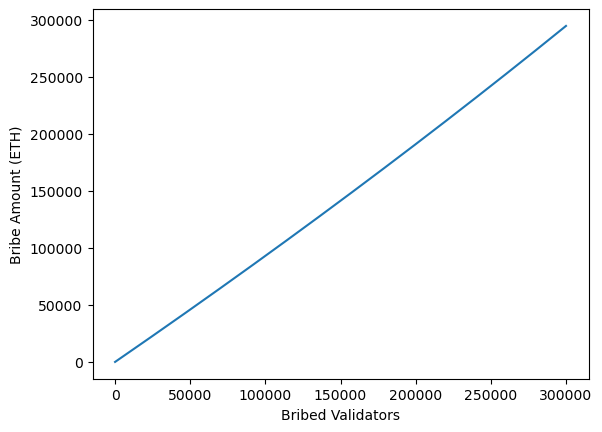

In [8]:
noOfBribedValidators = 300000

oneYearRewards = [
    32 * getAPR(i) / 100
    for i in range(noOfValidators, noOfValidators - noOfBribedValidators, -1)
]
bribeAmounts = np.cumsum(oneYearRewards)

plt.plot(bribeAmounts)
plt.xlabel("Bribed Validators")
plt.ylabel("Bribe Amount (ETH)")
plt.show()

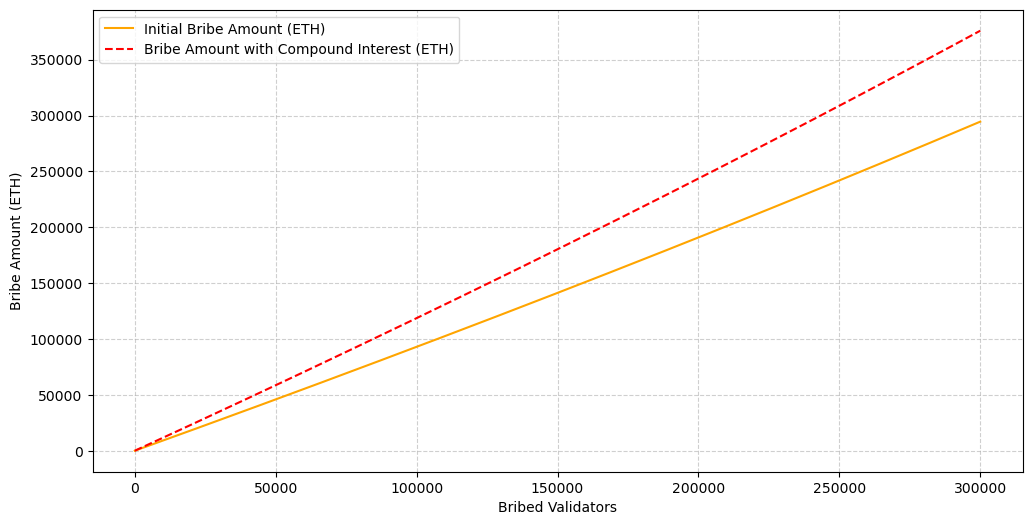

In [9]:
interest_rate = 0.05  # 5% annual interest rate
years = 5

bribeWithInterest = bribeAmounts * (1 + interest_rate) ** years

plt.figure(figsize=(12, 6))
plt.plot(bribeAmounts, label="Initial Bribe Amount (ETH)", color="orange")
plt.plot(
    bribeWithInterest,
    label="Bribe Amount with Compound Interest (ETH)",
    linestyle="--",
    color="red",
)
plt.xlabel("Bribed Validators")
plt.ylabel("Bribe Amount (ETH)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Pay To attest


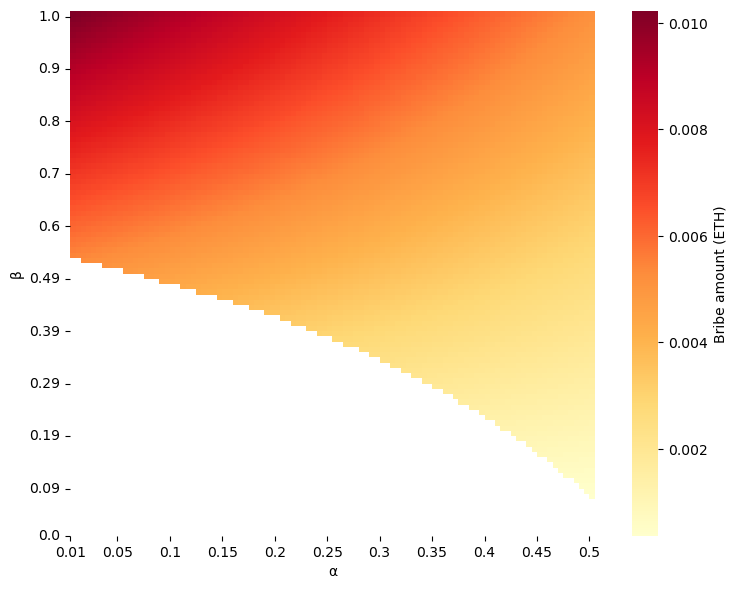

In [10]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)

# L = 2 # fork_lengths
# F0 = 2
# k = 0.1
# canonical_length = 2
# F = F0 * np.exp(-k * L)

bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):

        lhs = 2 * (1 - alpha) * (1 - beta)
        # lhs = F * (1 - beta) * (1 - alpha) * L + (1 - alpha) * canonical_length

        rhs = 0.4 + alpha + (1 - alpha) * beta
        # rhs = alpha * canonical_length + F * alpha * L + F * beta * (1 - alpha) * L

        if lhs < rhs:

            bribe[i, j] = (
                beta
                * (1 - alpha)
                * noOfValidators
                * attestation_reward_per_validator
                / 32
            )
            # bribe[i, j] = L * beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32

        # ábrázolni: (1-\alpha) \cdot \beta


vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center")
ax.invert_yaxis()

plt.tight_layout()
plt.show()

$$ \text{bribe} = \frac{\beta \cdot (1 - \alpha) \cdot noOfValidators \cdot attestation_reward_per_validator}{32} $$

$$ \text{rhs} = 0.4 + \alpha + (1 - \alpha) \cdot \beta $$

$$ \text{lhs} = 2 \cdot (1 - \alpha) \cdot (1 - \beta) $$


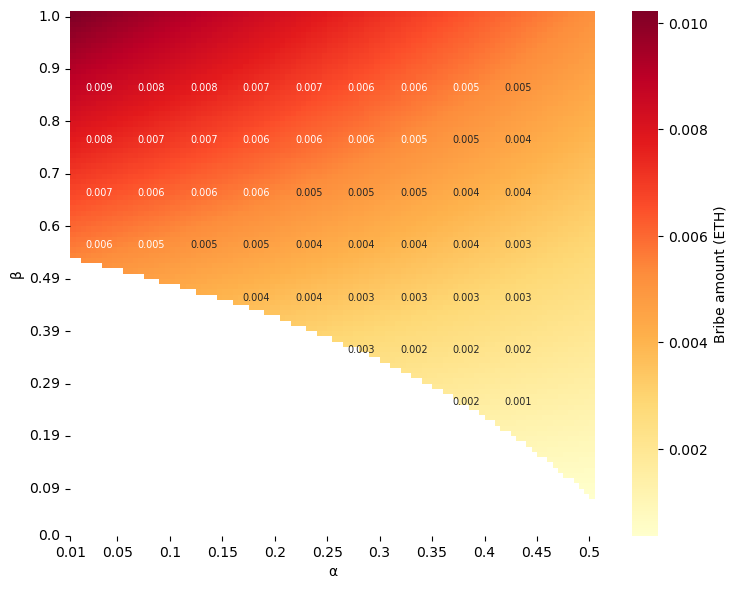

In [11]:
annot_data = np.empty_like(bribe, dtype=object)
annot_data[:, :] = ""

margin = 5

for i in range(margin, len(beta_vals) - margin, 10):
    for j in range(margin, len(alpha_vals) - margin, 10):
        if not np.isnan(bribe[i, j]):
            annot_data[i, j] = f"{bribe[i, j]:.3f}"


xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    annot=annot_data,
    fmt="",
    annot_kws={"size": 7, "ha": "center", "va": "center"},
)

ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0)
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Pay-To-Attest bribing timeline


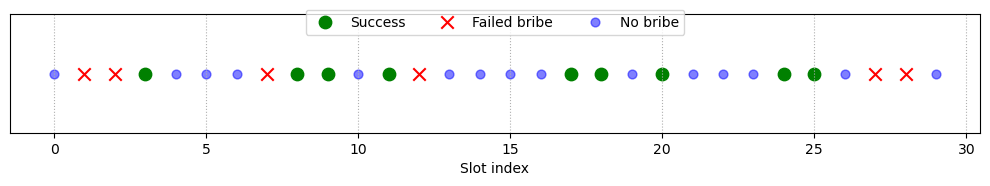

In [12]:
np.random.seed(42)
n_slots = 30

bribing_attempted = np.random.choice([0, 1], size=n_slots, p=[0.4, 0.6])
bribing_success = bribing_attempted * np.random.choice(
    [0, 1], size=n_slots, p=[0.3, 0.7]
)

slots = np.arange(n_slots)

plt.figure(figsize=(10, 2))
plt.scatter(
    slots[bribing_success == 1],
    [1] * sum(bribing_success == 1),
    color="green",
    label="Success",
    marker="o",
    s=80,
)
plt.scatter(
    slots[(bribing_attempted == 1) & (bribing_success == 0)],
    [1] * sum((bribing_attempted == 1) & (bribing_success == 0)),
    color="red",
    label="Failed bribe",
    marker="x",
    s=80,
)
plt.scatter(
    slots[bribing_attempted == 0],
    [1] * sum(bribing_attempted == 0),
    color="blue",
    label="No bribe",
    marker="o",
    s=40,
    alpha=0.5,
)

plt.yticks([])
plt.xlabel("Slot index")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.grid(axis="x", linestyle="dotted")
plt.tight_layout()
plt.show()

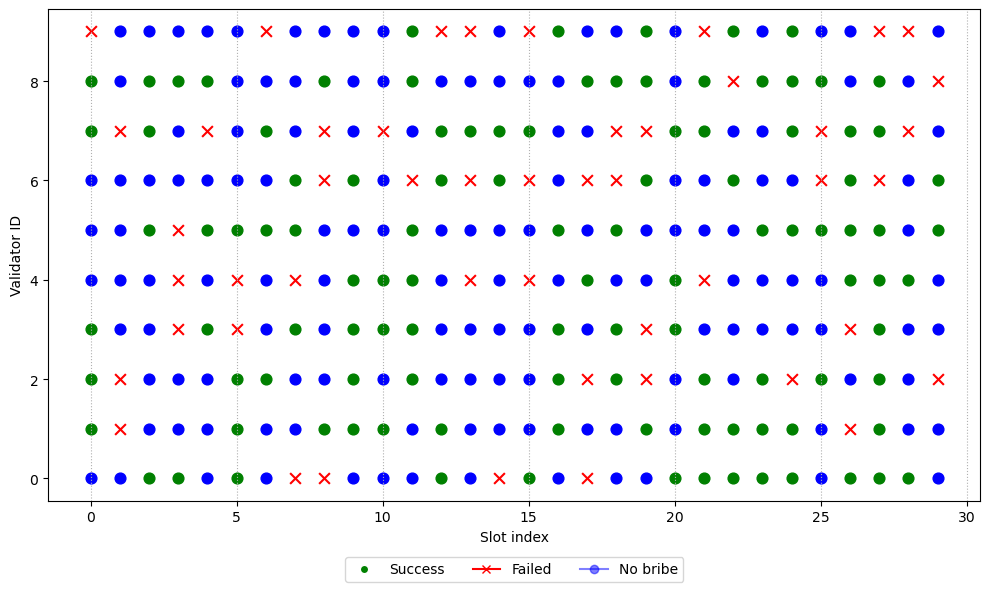

In [13]:
np.random.seed(42)
n_slots = 30
n_validators = 10

bribing_matrix = np.random.choice([0, 1], size=(n_slots, n_validators), p=[0.5, 0.5])
success_matrix = bribing_matrix * np.random.choice(
    [0, 1], size=(n_slots, n_validators), p=[0.3, 0.7]
)

fig, ax = plt.subplots(figsize=(10, 6))

for slot in range(n_slots):
    for val in range(n_validators):
        if bribing_matrix[slot, val] == 0:
            color, marker = "blue", "o"
        elif success_matrix[slot, val] == 1:
            color, marker = "green", "o"
        else:
            color, marker = "red", "x"
        ax.scatter(slot, val, color=color, marker=marker, s=60)

ax.set_xlabel("Slot index")
ax.set_ylabel("Validator ID")
ax.legend(
    handles=[
        plt.Line2D(
            [0], [0], marker="o", color="w", markerfacecolor="green", label="Success"
        ),
        plt.Line2D([0], [0], marker="x", color="red", label="Failed"),
        plt.Line2D([0], [0], marker="o", color="blue", label="No bribe", alpha=0.5),
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)
plt.grid(True, axis="x", linestyle="dotted")
plt.tight_layout()
plt.show()

- zöld = elfogadta a bribet és attesztált
- piros = bribing történt, de visszautasította
- kék = nem történt bribing


# Pay To Exit


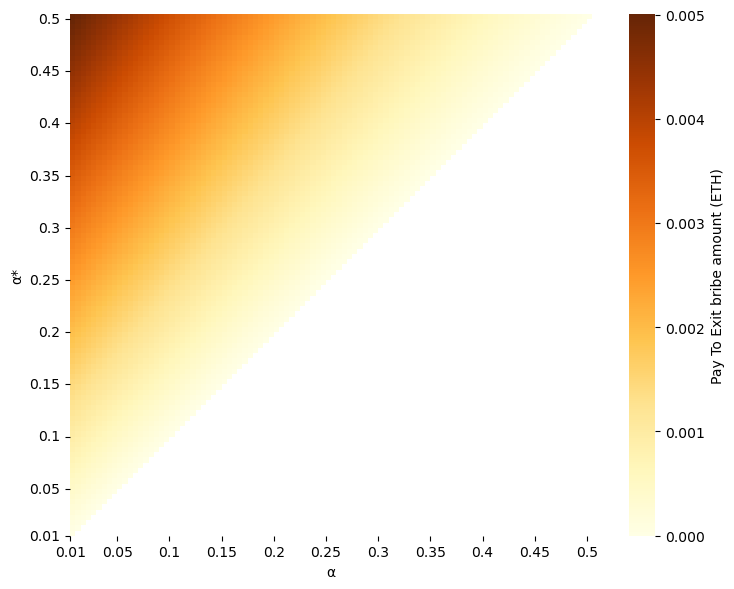

In [14]:
alpha_star_vals = np.linspace(0.01, 0.5, 100)

bribe_cost = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        if alpha_star >= alpha:
            bribe_cost[i, j] = (
                (alpha_star - alpha)
                * (1 - alpha)
                * noOfValidators
                * attestation_reward_per_validator
                / 32
            )


vmin = np.nanmin(bribe_cost)
vmax = np.nanmax(bribe_cost)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    bribe_cost,
    cmap="YlOrBr",
    mask=np.isnan(bribe_cost),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Pay To Exit bribe amount (ETH)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel("α")
ax.set_ylabel("α*")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center")
ax.invert_yaxis()

plt.tight_layout()
plt.show()

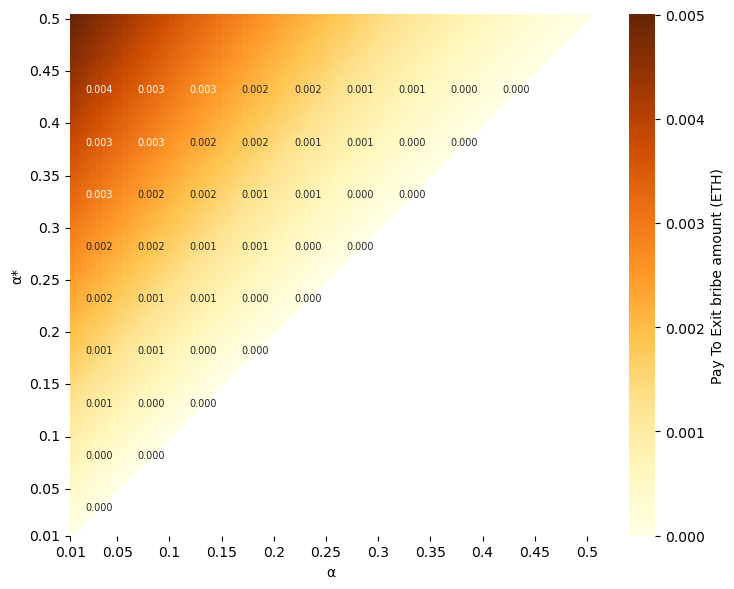

In [15]:
annot_data = np.empty_like(bribe_cost, dtype=object)
annot_data[:, :] = ""

margin = 5

for i in range(margin, len(alpha_star_vals) - margin, 10):
    for j in range(margin, len(alpha_vals) - margin, 10):
        if not np.isnan(bribe_cost[i, j]):
            annot_data[i, j] = f"{bribe_cost[i, j]:.3f}"

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    bribe_cost,
    cmap="YlOrBr",
    mask=np.isnan(bribe_cost),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Pay To Exit bribe amount (ETH)"},
    vmin=np.nanmin(bribe_cost),
    vmax=np.nanmax(bribe_cost),
    annot=annot_data,
    fmt="",
    annot_kws={"size": 7, "ha": "center", "va": "center"},
)

ax.set_xlabel("α")
ax.set_ylabel("α*")
ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0)
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [16]:
def compute_bribe_cost(alpha, alpha_star):
    if alpha_star < alpha:
        return np.nan

    current_validators = int(alpha * noOfValidators)
    target_validators = int(alpha_star * noOfValidators)
    bribed = target_validators - current_validators

    if bribed <= 0:
        return np.nan

    one_year_rewards = [
        32 * getAPR(i) / 100
        for i in range(current_validators, current_validators + bribed)
    ]
    # oneYearRewards = [32 * getAPR(i) / 100 for i in range(noOfValidators, noOfValidators - noOfBribedValidators, -1)]
    bribe_amounts = np.cumsum(one_year_rewards)

    bribe_with_interest = bribe_amounts * (1 + interest_rate) ** years

    return bribe_with_interest[-1]


bribe_cost = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        bribe_cost[i, j] = compute_bribe_cost(alpha, alpha_star)


vmin = np.nanmin(bribe_cost)
vmax = np.nanmax(bribe_cost)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    bribe_cost,
    cmap="YlOrBr",
    mask=np.isnan(bribe_cost),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Pay To Exit bribe amount (ETH)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel("α")
ax.set_ylabel("α*")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center")
ax.invert_yaxis()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Pay-To-Exit gas cost vs number of blocks


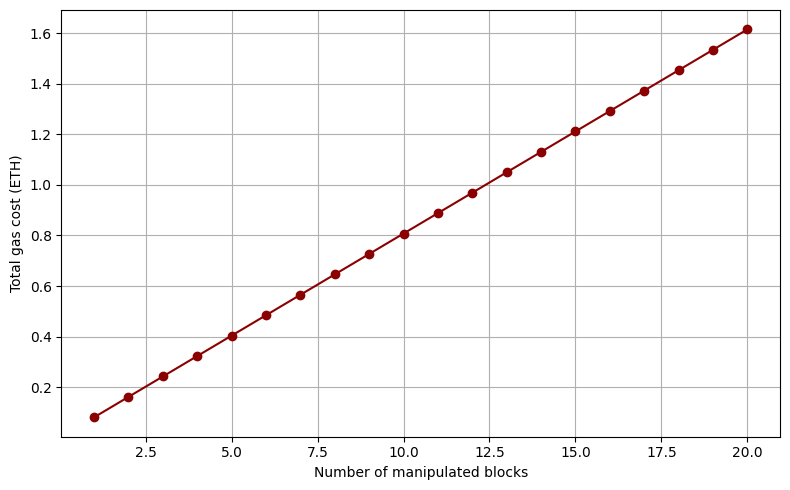

In [ ]:
validators_per_block = 32
offer_gas = 60000
take_gas = 1150660
total_gas_per_validator = offer_gas + take_gas

gwei_price = 2.084 / 1e9
eth_usd_price = 3668.77

blocks = list(range(1, 21))
eth_costs = []
usd_costs = []

for b in blocks:
    total_validators = b * validators_per_block
    total_gas = total_validators * total_gas_per_validator
    eth_cost = total_gas * gwei_price
    usd_cost = eth_cost * eth_usd_price
    eth_costs.append(eth_cost)
    usd_costs.append(usd_cost)

plt.figure(figsize=(8, 5))
plt.plot(blocks, eth_costs, marker="o", color="darkred")
plt.xlabel("Number of manipulated blocks")
plt.ylabel("Total gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

- the total gas cost increases with the number of blocks a briber attempts to manipulate in order to force a validator to exit the system
- each block requires bribing 32 validators using both offerBribe() and takeBribe() functions
- making the cost grow linearly with the number of targeted blocks


### Pay-To-Exit cost and block duration


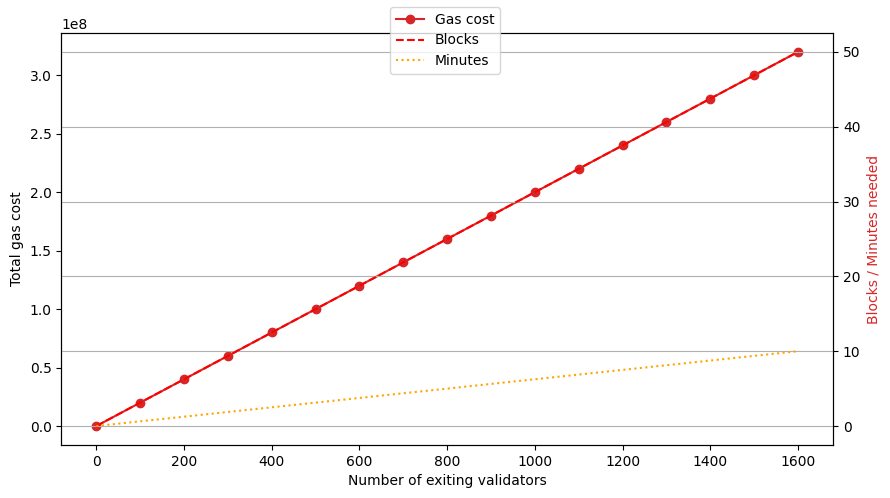

In [ ]:
validators_to_exit = list(range(0, 1601, 100))
gas_per_validator = 200_000
validators_per_block = 32
block_time_seconds = 12

total_gas = [v * gas_per_validator for v in validators_to_exit]
blocks_needed = [v / validators_per_block for v in validators_to_exit]
time_minutes = [b * block_time_seconds / 60 for b in blocks_needed]

fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.set_xlabel("Number of exiting validators")
ax1.set_ylabel("Total gas cost")
ax1.plot(validators_to_exit, total_gas, color=color, marker="o", label="Gas cost")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Blocks / Minutes needed", color=color)
ax2.plot(validators_to_exit, blocks_needed, color="red", linestyle="--", label="Blocks")
ax2.plot(
    validators_to_exit, time_minutes, color="orange", linestyle=":", label="Minutes"
)
ax2.tick_params(axis="y")

fig.tight_layout()
fig.legend(loc="upper center")
plt.grid(True)
plt.show()

## Countermeasures


In [ ]:
date_range = pd.date_range(start="2020-01-01", end="2025-01-01", freq="D")
num_days = len(date_range)

eth_supply = 110 + 0.005 * (
    pd.Series(range(num_days)) + (np.random.randn(num_days) * 0.2).cumsum()
)
eth_supply = eth_supply.round(3)

price = (
    2000
    + (np.sin(np.linspace(0, 20, num_days)) * 200)
    + (np.random.randn(num_days) * 100).cumsum()
)
price = pd.Series(price).clip(lower=100)

df = pd.DataFrame(
    {"date": date_range, "eth_supply_millions": eth_supply, "eth_usd_price": price}
)
df["eth_supply"] = df["eth_supply_millions"] * 1e6  # millió -> darabszám

df["eth_inflation"] = df["eth_supply"].pct_change()

df["price_return"] = df["eth_usd_price"].pct_change()

df.dropna(inplace=True)

df["eth_inflation_percent"] = df["eth_inflation"] * 100

print(df.tail())

           date  eth_supply_millions  eth_usd_price   eth_supply  \
1823 2024-12-28              119.121          100.0  119121000.0   
1824 2024-12-29              119.127          100.0  119127000.0   
1825 2024-12-30              119.130          100.0  119130000.0   
1826 2024-12-31              119.135          100.0  119135000.0   
1827 2025-01-01              119.137          100.0  119137000.0   

      eth_inflation  price_return  eth_inflation_percent  
1823       0.000042           0.0               0.004198  
1824       0.000050           0.0               0.005037  
1825       0.000025           0.0               0.002518  
1826       0.000042           0.0               0.004197  
1827       0.000017           0.0               0.001679  


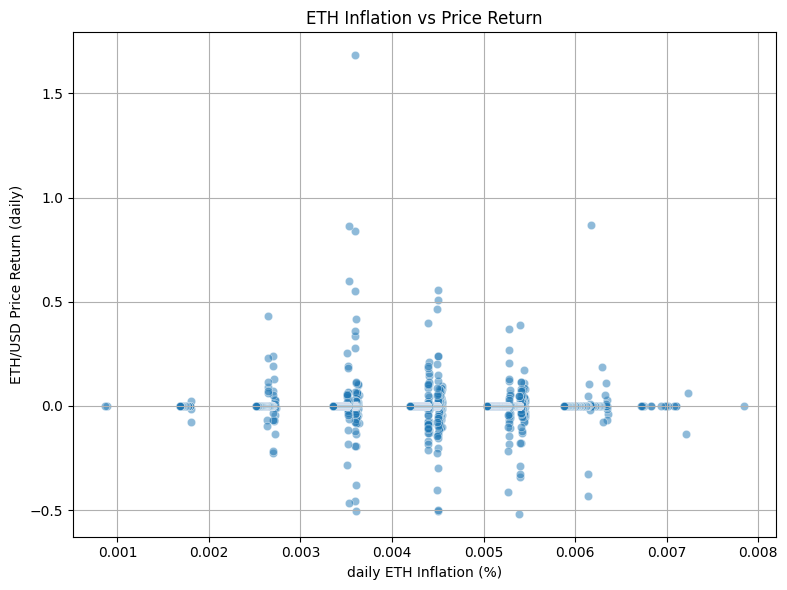

Korreláció: -0.0336
                            OLS Regression Results                            
Dep. Variable:           price_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.061
Date:                Fri, 25 Jul 2025   Prob (F-statistic):              0.151
Time:                        12:55:07   Log-Likelihood:                 1936.3
No. Observations:                1827   AIC:                            -3869.
Df Residuals:                    1825   BIC:                            -3858.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0141  

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=(8, 6))
sns.scatterplot(x="eth_inflation_percent", y="price_return", data=df, alpha=0.5)
plt.xlabel("daily ETH Inflation (%)")
plt.ylabel("ETH/USD Price Return (daily)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
correlation = df["eth_inflation"].corr(df["price_return"])
print(f"Korreláció: {correlation:.4f}")

# Linear regression
X = sm.add_constant(df["eth_inflation"])
y = df["price_return"]
model = sm.OLS(y, X).fit()
print(model.summary())

## Pay to bias: gas cost vs number of tail slots


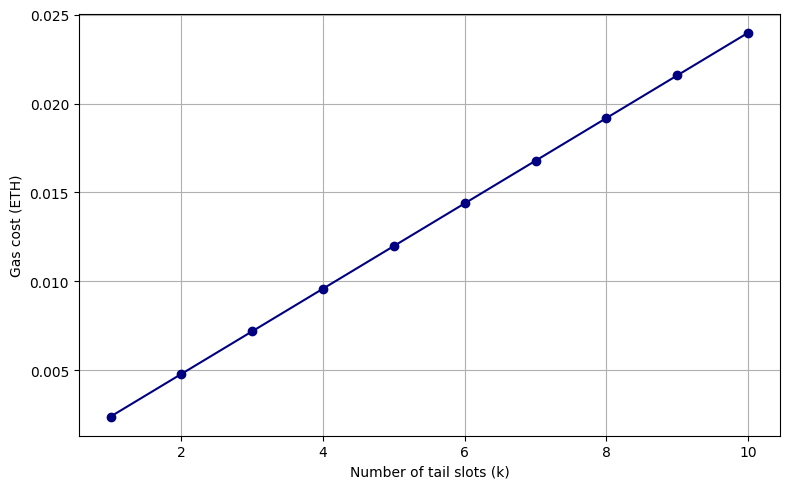

In [ ]:
tail_slots = list(range(1, 11))

base_gas_per_verification = 1150660  # from Table2

gas_costs = [k * base_gas_per_verification for k in tail_slots]

eth_usd_price = 3668.77
gwei_price = 2.084 / 1e9  # ETH
usd_costs = [gas * gwei_price * eth_usd_price for gas in gas_costs]
eth_costs = [gas * gwei_price for gas in gas_costs]


plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_costs, marker="o", color="navy")
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

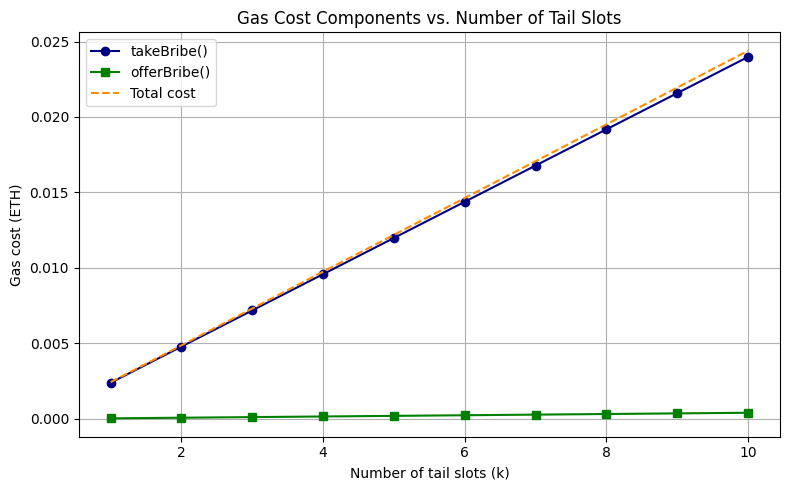

In [ ]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9
eth_usd_price = 3668.77

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]
eth_cost_total = [take + offer for take, offer in zip(eth_cost_take, eth_cost_offer)]

plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_cost_take, label="takeBribe()", marker="o", color="navy")
plt.plot(tail_slots, eth_cost_offer, label="offerBribe()", marker="s", color="green")
plt.plot(
    tail_slots, eth_cost_total, label="Total cost", linestyle="--", color="darkorange"
)

plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Histogram


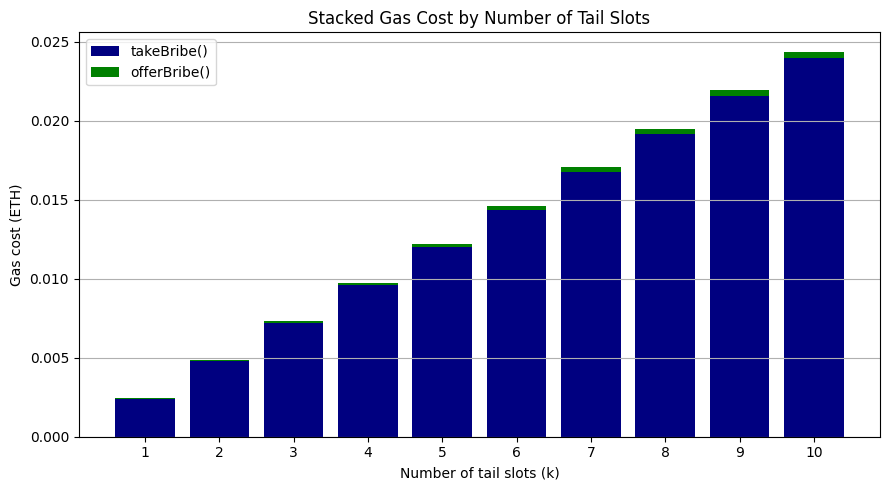

In [ ]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]

x = np.arange(len(tail_slots))

plt.figure(figsize=(9, 5))
plt.bar(x, eth_cost_take, label="takeBribe()", color="navy")
plt.bar(x, eth_cost_offer, bottom=eth_cost_take, label="offerBribe()", color="green")

plt.xticks(x, tail_slots)
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

- shows how the total gas cost increases as the attacker attempts to influence more tail slots
- for each slot the attacker must call both offerBribe() and takeBribe()
- which together make the cost grow linearly with the number of slots


#### Gas Cost vs. Published Slot Ratio


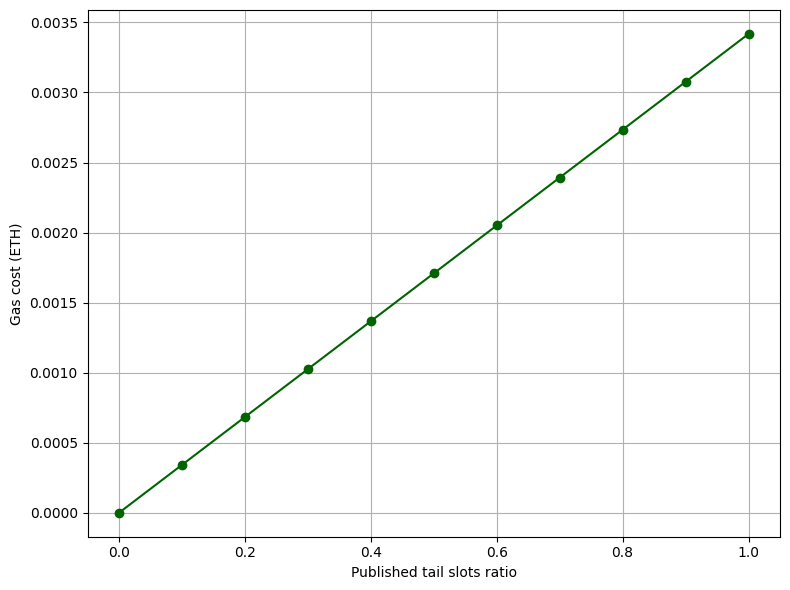

In [ ]:
k = 10  # tail slot
gas_per_slot = 93156
gas_price_gwei = 3.66877
gwei_to_eth = 1e-9

ratios = np.linspace(0, 1, 11)

published_slots = ratios * k

total_gas = published_slots * gas_per_slot
total_eth_cost = total_gas * gas_price_gwei * gwei_to_eth

plt.figure(figsize=(8, 6))
plt.plot(ratios, total_eth_cost, marker="o", color="darkgreen")
plt.xlabel("Published tail slots ratio")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Bribery Timeline in Pay-to-Bias


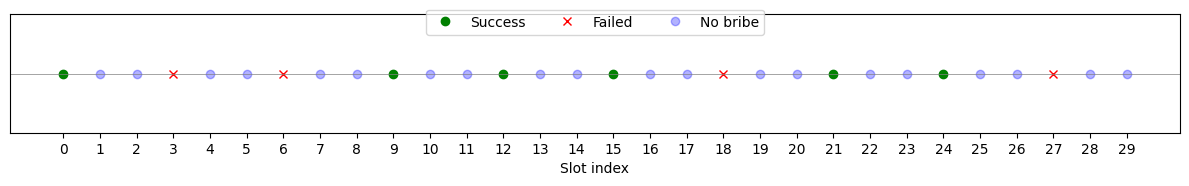

In [ ]:
# np.random.seed(42)

num_slots = 30
bias_threshold = 0.6
slots = np.arange(num_slots)

bribe_offered = np.zeros(num_slots, dtype=bool)
bribe_offered[::3] = True

bribe_successful = np.zeros(num_slots, dtype=bool)
bribe_successful[bribe_offered] = np.random.rand(np.sum(bribe_offered)) > 0.3

plt.figure(figsize=(12, 2))
plt.plot([], [], "go", label="Success")
plt.plot([], [], "rx", label="Failed")
plt.plot([], [], "bo", alpha=0.3, label="No bribe")

for i in range(num_slots):
    if bribe_offered[i]:
        if bribe_successful[i]:
            plt.plot(i, 0, "go")
        else:
            plt.plot(i, 0, "rx")
    else:
        plt.plot(i, 0, "bo", alpha=0.3)

plt.axhline(0, color="gray", linewidth=0.5)
plt.xticks(slots)
plt.yticks([])
plt.xlabel("Slot index")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.tight_layout()
plt.show()

- the outcome of bribing attempts across 30 consecutive slots, each point represents a slot
- Green dots: successful bribing, where the attacker’s manipulated block was published
- Red X marks: failed bribing attempts, where a bribe was offered but did not result in a successful publication
- Blue circles represent no bribing attempt in that slot.


# Pay to attest


# Nem fontos


### Színskálák értelmezése

- kék színskála: adott alpha (a bribelt validátor részesedése) és beta (a bribelt stake aránya) értékeknél mekkora az attack success, vagyis mennyivel több jutalmat kapna a validátor, ha elfogadná a megvesztegetést, mint ha a honest blokkot támogatná
- piros színskála: a támadónak szükséges megvesztegetési költséget mutatja


### Második verzio:

- allithato canonical_length
- honest validator jutalma nem csak az azonnali blokk jutalombol all, hanem a kanonikus lancon elert tovabbi jutalmakbol
  lhs = F _ (1 - beta) _ (1 - alpha) _ L + D _ (1 - alpha) \* canonical_length
- nagyobbak az ertekekek mert nott a jutalom is, igy tobb jutalmat kell kinalnia a tamadonak (noveli az rhs-lhs kulonbseget es csak nagyobb beta es kisebb alpha tartomanyban eri csak meg a tamadas)
- Csokken a tamadas nyeresege, ahogy no a fork hossza (exponencialisan) F = F0 _ np.exp(-k _ L)


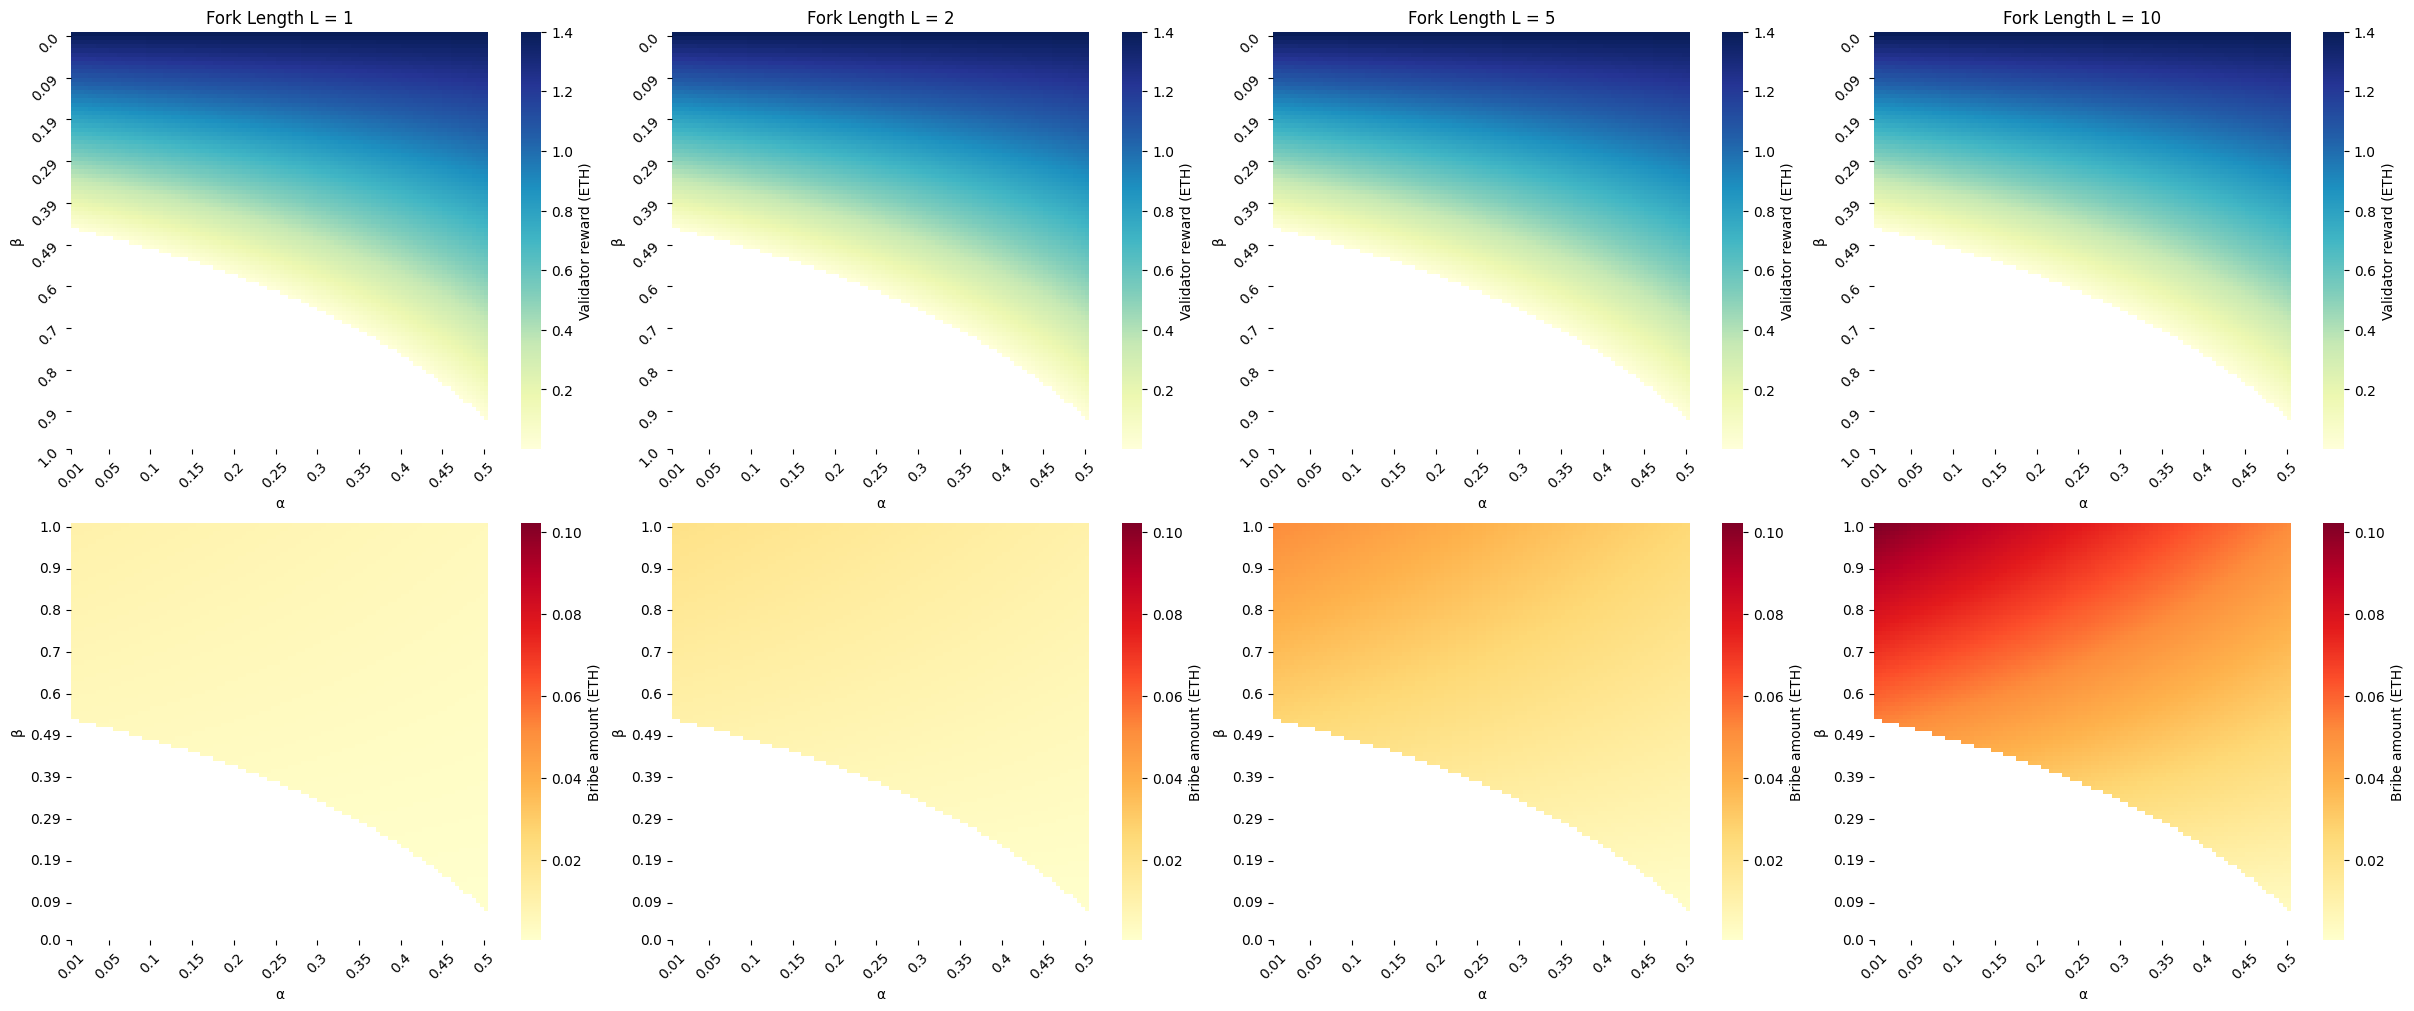

In [ ]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)
fork_lengths = [1, 2, 5, 10]

F0 = 2
k = 0.1

canonical_length = 2

heatmaps_success = []
heatmaps_bribe = []

for L in fork_lengths:
    F = F0 * np.exp(-k * L)
    success = np.full((len(beta_vals), len(alpha_vals)), np.nan)
    bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

    for i, beta in enumerate(beta_vals):
        for j, alpha in enumerate(alpha_vals):
            lhs = 2 * (1 - alpha) * (1 - beta)
            # lhs = F * (1 - beta) * (1 - alpha) * L + (1 - alpha) * canonical_length
            rhs = 0.4 + alpha + (1 - alpha) * beta
            # rhs = alpha * canonical_length + F * alpha * L + F * beta * (1 - alpha) * L

            if lhs < rhs:
                success[i, j] = rhs - lhs
                bribe[i, j] = (
                    L
                    * beta
                    * (1 - alpha)
                    * noOfValidators
                    * attestation_reward_per_validator
                    / 32
                )

                # ábrázolni: (1-\alpha) \cdot \beta
    heatmaps_success.append(success)
    heatmaps_bribe.append(bribe)


vmin_success = np.nanmin(heatmaps_success)
vmax_success = np.nanmax(heatmaps_success)

vmin_bribe = np.nanmin(heatmaps_bribe)
vmax_bribe = np.nanmax(heatmaps_bribe)

fig, axs = plt.subplots(2, len(fork_lengths), figsize=(24, 10), constrained_layout=True)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

for idx in range(len(fork_lengths)):
    sns.heatmap(
        heatmaps_success[idx],
        cmap="YlGnBu",
        mask=np.isnan(heatmaps_success[idx]),
        xticklabels=False,
        yticklabels=False,
        square=True,
        ax=axs[0, idx],
        linewidths=0,
        linecolor="none",
        cbar_kws={"label": "Validator reward (ETH)"},
        vmin=vmin_success,
        vmax=vmax_success,
    )

    axs[0, idx].set_title(f"Fork Length L = {fork_lengths[idx]}")
    axs[0, idx].set_xlabel("α")
    axs[0, idx].set_ylabel("β")
    axs[0, idx].set_xticks(xticks_idx)
    axs[0, idx].set_xticklabels(xticks, rotation=45)
    axs[0, idx].set_yticks(yticks_idx)
    axs[0, idx].set_yticklabels(yticks[::-1], rotation=45)
    axs[0, idx].invert_yaxis()

    sns.heatmap(
        heatmaps_bribe[idx],
        cmap="YlOrRd",
        mask=np.isnan(heatmaps_bribe[idx]),
        xticklabels=False,
        yticklabels=False,
        square=True,
        ax=axs[1, idx],
        linewidths=0,
        linecolor="none",
        cbar_kws={"label": "Bribe amount (ETH)"},
        vmin=vmin_bribe,
        vmax=vmax_bribe,
    )

    axs[1, idx].set_xlabel("α")
    axs[1, idx].set_ylabel("β")
    axs[1, idx].set_xticks(xticks_idx)
    axs[1, idx].set_xticklabels(xticks, rotation=45)
    axs[1, idx].set_yticks(yticks_idx)
    axs[1, idx].set_yticklabels(yticks, rotation=0, va="center")
    axs[1, idx].invert_yaxis()

plt.show()

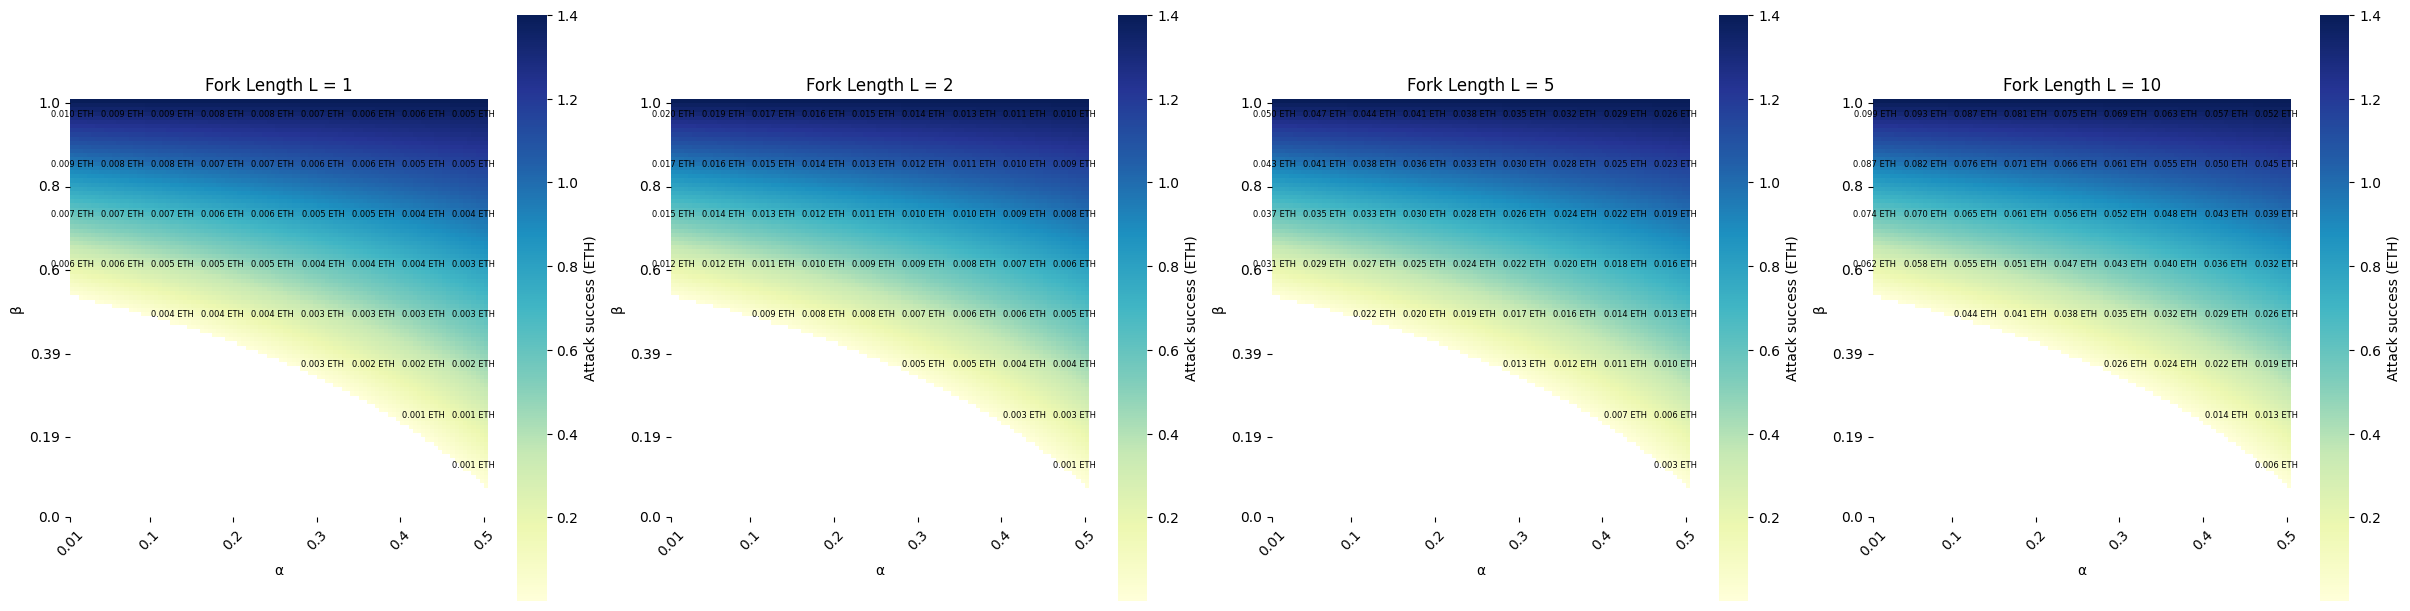

In [ ]:
# Egy abran a sikeresseg es a bribe osszege

fig, axs = plt.subplots(1, len(fork_lengths), figsize=(24, 6), constrained_layout=True)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 6, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 6, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

for idx in range(len(fork_lengths)):
    ax = axs[idx]

    sampled_bribe = heatmaps_bribe[idx].copy()
    for i in range(len(beta_vals)):
        for j in range(len(alpha_vals)):
            if i % 12 != 0 or j % 12 != 0:
                sampled_bribe[i, j] = np.nan

    annotations = np.empty_like(sampled_bribe, dtype=object)
    for i in range(len(beta_vals)):
        for j in range(len(alpha_vals)):
            if not np.isnan(sampled_bribe[i, j]):
                annotations[i, j] = f"{sampled_bribe[i, j]:.3f} ETH"
            else:
                annotations[i, j] = ""

    sns.heatmap(
        heatmaps_success[idx],
        cmap="YlGnBu",
        mask=np.isnan(heatmaps_success[idx]),
        square=True,
        ax=ax,
        cbar_kws={"label": "Attack success (ETH)"},
        annot=annotations,
        fmt="",
        annot_kws={"size": 6, "color": "black"},
        vmin=vmin_success,
        vmax=vmax_success,
    )

    ax.set_title(f"Fork Length L = {fork_lengths[idx]}")
    ax.set_xlabel("α")
    ax.set_ylabel("β")

    ax.set_xticks(xticks_idx)
    ax.set_xticklabels(xticks, rotation=45)

    ax.set_yticks(yticks_idx)
    ax.set_yticklabels(yticks, rotation=0, va="center")
    ax.invert_yaxis()

plt.show()

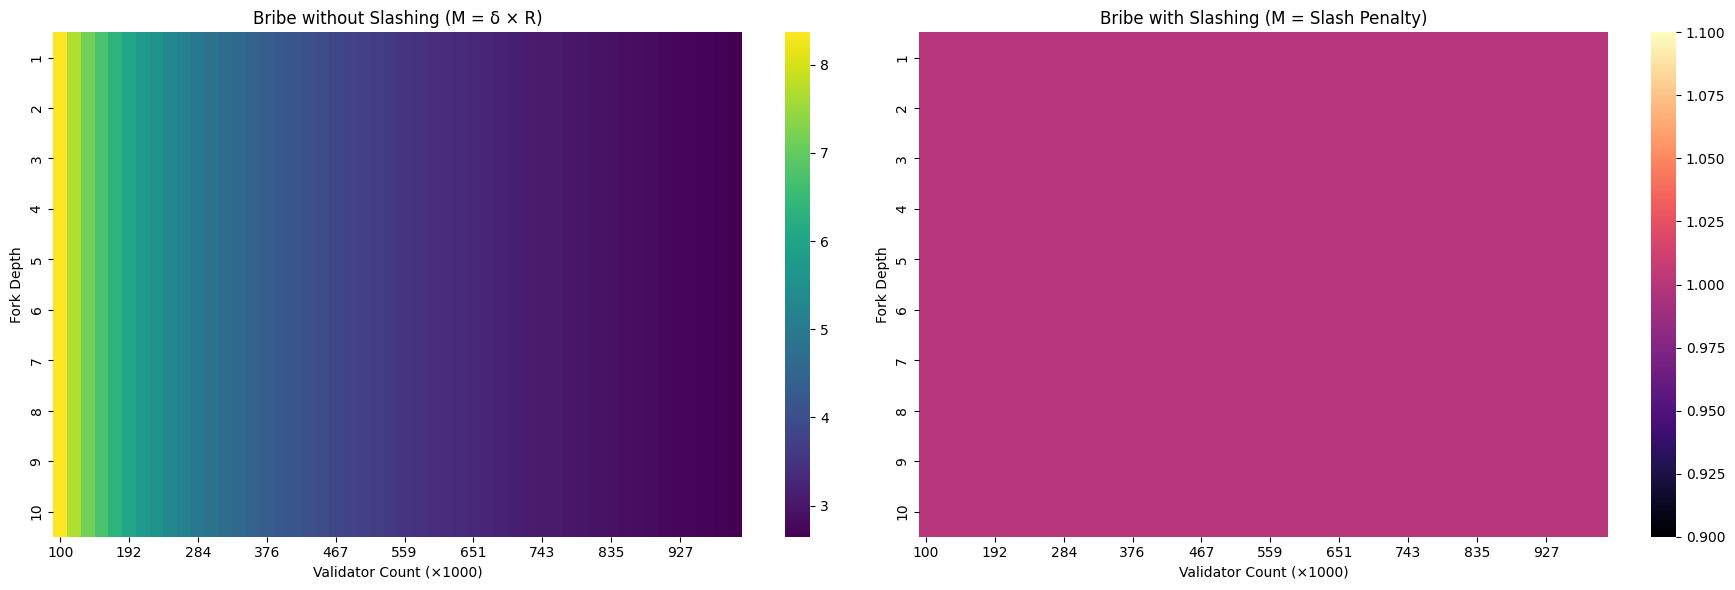

In [ ]:
delta = 0.9  # time discount factor
k = 2940.21  # reward constant, approx.
slash_fraction = 1 / 32  # base slashing penalty (simplified)
base_stake = 32  # ETH per validator


def honest_reward(N):
    return k / np.sqrt(N)


def slash_penalty():
    return slash_fraction * base_stake


validator_range = np.linspace(100_000, 1_000_000, 50)
fork_depth_range = np.arange(1, 11)  # from 1 to 10 blocks deep
X, Y = np.meshgrid(validator_range, fork_depth_range)

reward_grid = delta * honest_reward(X)
slashing_grid = slash_penalty() * np.ones_like(X)  # constant

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(reward_grid, ax=axs[0], xticklabels=5, yticklabels=1, cmap="viridis")
axs[0].set_title("Bribe without Slashing (M = δ × R)")
axs[0].set_xlabel("Validator Count (×1000)")
axs[0].set_ylabel("Fork Depth")
axs[0].set_xticklabels(np.round(validator_range[::5] / 1_000).astype(int))
axs[0].set_yticklabels(fork_depth_range)

sns.heatmap(slashing_grid, ax=axs[1], xticklabels=5, yticklabels=1, cmap="magma")
axs[1].set_title("Bribe with Slashing (M = Slash Penalty)")
axs[1].set_xlabel("Validator Count (×1000)")
axs[1].set_ylabel("Fork Depth")
axs[1].set_xticklabels(np.round(validator_range[::5] / 1_000).astype(int))
axs[1].set_yticklabels(fork_depth_range)

plt.tight_layout()
plt.show()

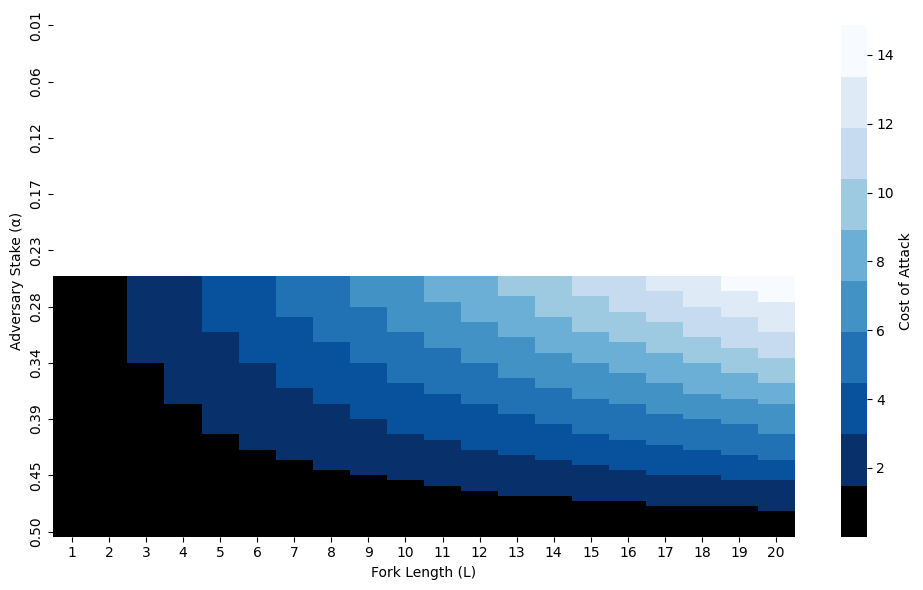

In [ ]:
from matplotlib.colors import ListedColormap


fork_lengths = np.arange(1, 21)  # fork hossza
alpha_vals = np.linspace(0.01, 0.5, 100)  # adversary stake

F = 1  # reward on the fork
D = 2  # reward on canonical chain
unit_cost = 1  # cost per unit bribed stake

cost_matrix = np.full((len(alpha_vals), len(fork_lengths)), np.nan)

for i, alpha in enumerate(alpha_vals):
    for j, L in enumerate(fork_lengths):
        betas = np.linspace(0, 1, 1000)
        for beta in betas:
            lhs = F * (1 - beta) * (1 - alpha) * L + D * (1 - alpha) * L
            rhs = D * alpha * L + F * alpha * L + F * beta * (1 - alpha) * L
            if lhs < rhs:
                cost_matrix[i, j] = beta * (1 - alpha) * unit_cost * L
                break

colors = [
    "black",
    "#08306b",
    "#08519c",
    "#2171b5",
    "#4292c6",
    "#6baed6",
    "#9ecae1",
    "#c6dbef",
    "#deebf7",
    "#f7fbff",
]
cmap = ListedColormap(colors)


plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    cost_matrix,
    xticklabels=fork_lengths,
    cmap=cmap,
    mask=np.isnan(cost_matrix),
    cbar_kws={"label": "Cost of Attack"},
)

ytick_indices = np.linspace(0, len(alpha_vals) - 1, 10, dtype=int)
ytick_labels = [f"{alpha_vals[i]:.2f}" for i in ytick_indices]
ax.set_yticks(ytick_indices)
ax.set_yticklabels(ytick_labels)

plt.xlabel("Fork Length (L)")
plt.ylabel("Adversary Stake (α)")
plt.tight_layout()
plt.show()

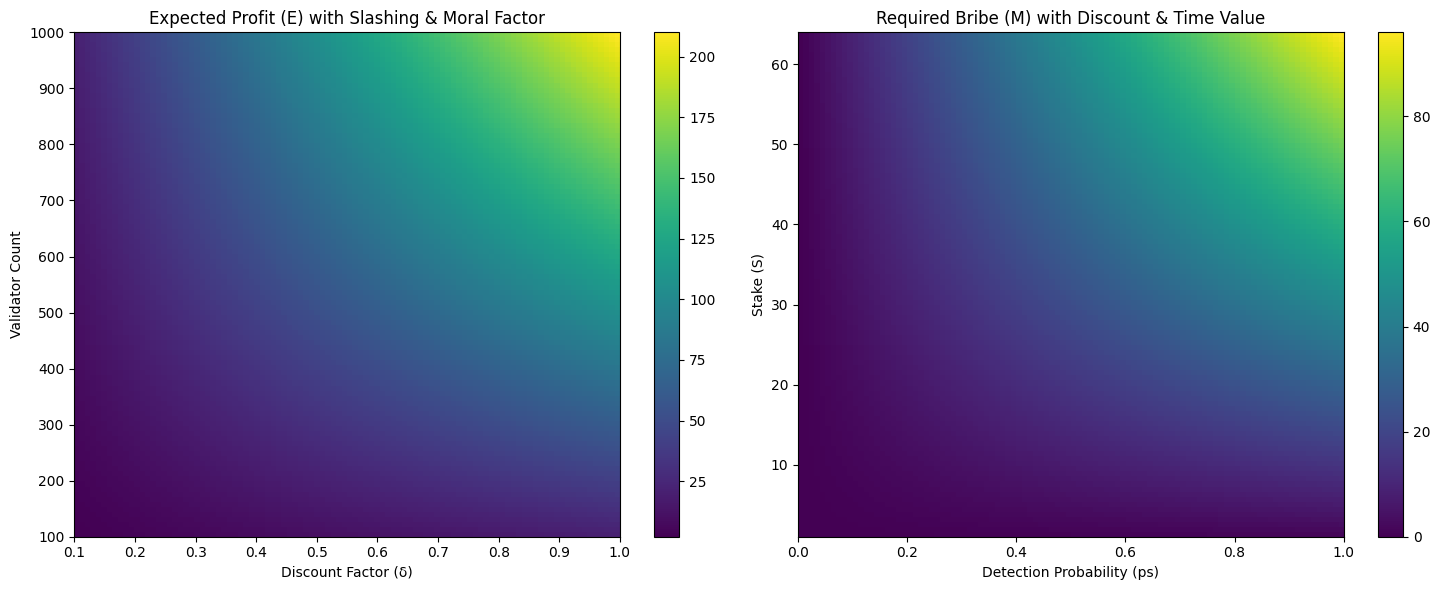

In [ ]:
validator_count_range = np.linspace(100, 1000, 100)
delta_range = np.linspace(0.1, 1, 100)
ps_range = np.linspace(0, 1, 100)
stake_range = np.linspace(1, 64, 100)


def generate_dynamic_heatmaps(alpha=0.5, ps=0.5, delta=0.9, time_value=0.1):
    X1, Y1 = np.meshgrid(delta_range, validator_count_range)
    expected_profit = X1 * Y1 * (1 - ps) * (1 - alpha)

    X2, Y2 = np.meshgrid(ps_range, stake_range)
    required_bribe = X2 * Y2 * (1 + time_value) / delta

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    im1 = axs[0].imshow(
        expected_profit,
        aspect="auto",
        origin="lower",
        extent=[
            delta_range.min(),
            delta_range.max(),
            validator_count_range.min(),
            validator_count_range.max(),
        ],
    )
    axs[0].set_title("Expected Profit (E) with Slashing & Moral Factor")
    axs[0].set_xlabel("Discount Factor (δ)")
    axs[0].set_ylabel("Validator Count")
    fig.colorbar(im1, ax=axs[0])

    im2 = axs[1].imshow(
        required_bribe,
        aspect="auto",
        origin="lower",
        extent=[ps_range.min(), ps_range.max(), stake_range.min(), stake_range.max()],
    )
    axs[1].set_title("Required Bribe (M) with Discount & Time Value")
    axs[1].set_xlabel("Detection Probability (ps)")
    axs[1].set_ylabel("Stake (S)")
    fig.colorbar(im2, ax=axs[1])

    plt.tight_layout()
    plt.show()


generate_dynamic_heatmaps(alpha=0.3, ps=0.7, delta=0.8, time_value=0.2)

In [17]:
different_messages_data = [
    (1, 163797, 163797),
    (2, 252893, 126446),
    (3, 342026, 114008),
    (4, 431189, 107797),
    (5, 520386, 104077),
    (6, 609624, 101604),
    (7, 698909, 99844),
    (8, 788248, 98531),
    (9, 877644, 97516),
    (10, 967106, 96710),
    (11, 1056637, 96057),
    (12, 1146244, 95520),
    (13, 1235934, 95071),
    (14, 1325711, 94693),
    (15, 1415581, 94372),
    (16, 1505551, 94096),
    (17, 1595626, 93860),
    (18, 1685811, 93656),
    (19, 1776113, 93479),
    (20, 1866538, 93326),
    (21, 1957090, 93194),
    (22, 2047778, 93080),
    (23, 2138604, 92982),
    (24, 2229577, 92899),
    (25, 2320700, 92828),
]

same_message_data = [
    (1, 161833, 161833),
    (2, 161840, 80920),
    (3, 161849, 53949),
    (4, 161862, 40465),
    (5, 161877, 32375),
    (6, 161896, 26982),
    (7, 161917, 23131),
    (8, 161941, 20242),
    (9, 161968, 17996),
    (10, 161999, 16199),
    (11, 162031, 14730),
    (12, 162067, 13505),
    (13, 162105, 12469),
    (14, 162147, 11581),
    (15, 162192, 10812),
    (16, 162239, 10139),
    (17, 162289, 9546),
    (18, 162342, 9019),
    (19, 162399, 8547),
    (20, 162458, 8122),
    (21, 162520, 7739),
    (22, 162585, 7390),
    (23, 162652, 7071),
    (24, 162723, 6780),
    (25, 162797, 6511),
]

df_different = pd.DataFrame(
    different_messages_data, columns=["messages", "total_gas", "gas_per_message"]
)
df_same = pd.DataFrame(
    same_message_data, columns=["messages", "total_gas", "gas_per_message"]
)

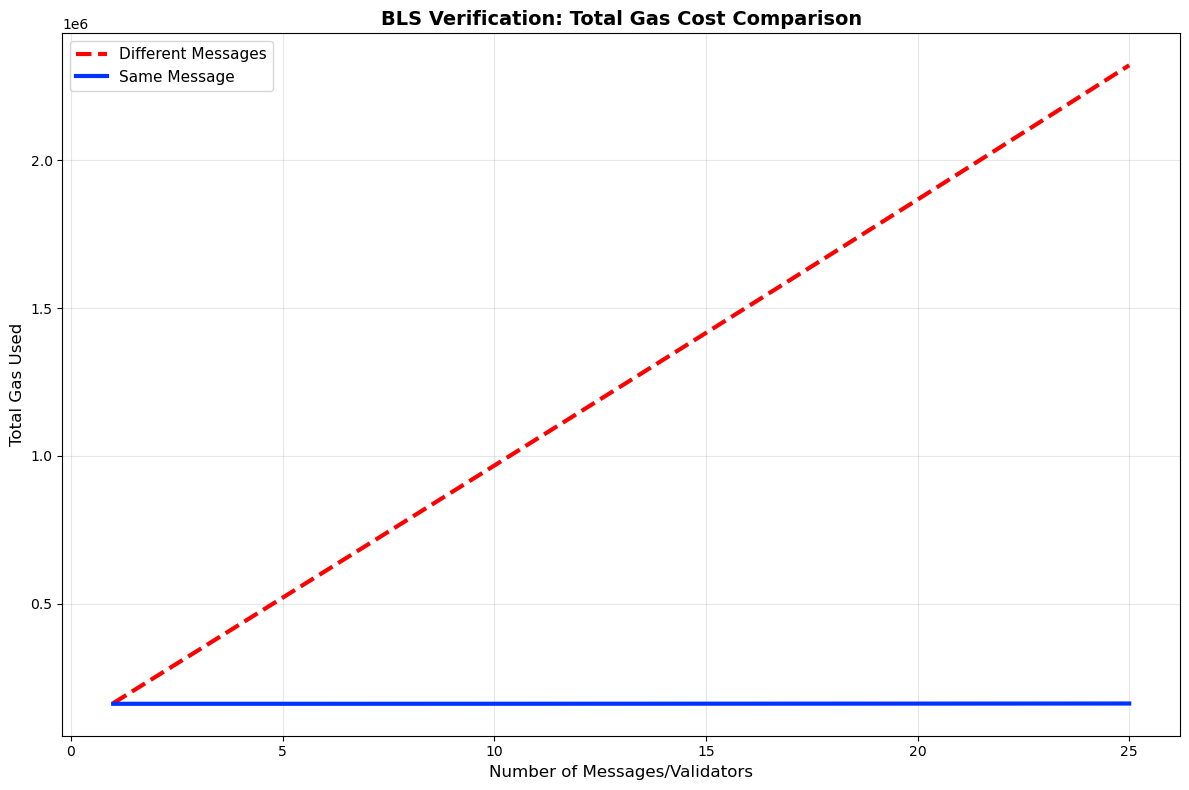

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

ax1.plot(
    df_different["messages"],
    df_different["total_gas"],
    "--",
    color="#FF0000",
    linewidth=3,
    markersize=6,
    label="Different Messages",
)
ax1.plot(
    df_same["messages"],
    df_same["total_gas"],
    "-",
    color="#0033FF",
    linewidth=3,
    markersize=6,
    label="Same Message",
)
ax1.set_xlabel("Number of Messages/Validators", fontsize=12)
ax1.set_ylabel("Total Gas Used", fontsize=12)
ax1.set_title(
    "BLS Verification: Total Gas Cost Comparison", fontsize=14, fontweight="bold"
)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

plt.tight_layout()
plt.show()